In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd
import numpy as np
import scipy
import yaml
import matplotlib.pyplot as plt

sys.path.append('../')

from abacus.auto_ab.abtest import ABTest
from abacus.auto_ab.params import ABTestParams
from abacus.auto_ab.params import DataParams, HypothesisParams
from abacus.splitter.split_builder import SplitBuilder
from abacus.splitter.params import SplitBuilderParams
from abacus.mde_researcher.params import MdeParams
from abacus.mde_researcher.mde_research_builder import MdeResearchBuilder
from abacus.mde_researcher.multiple_split_builder import MultipleSplitBuilder


logging.basicConfig(level = logging.INFO)


%load_ext autoreload
%autoreload 2

# Готовим данные

In [2]:
n_rows = 200_000

d = pd.DataFrame(data={
    'groups': np.random.choice(['control', 'treatment'], p=[0.5, 0.5], size=n_rows),
})

control_len = d.loc[d.groups == 'control'].shape[0]
treatment_len = d.loc[d.groups == 'treatment'].shape[0]

# user_id
d.loc[d.groups == 'control', 'user_id'] = np.random.randint(1, control_len-1500, control_len)
d.loc[d.groups == 'treatment', 'user_id'] = np.random.randint(control_len-1500+1, control_len-1500+1+treatment_len-1500, treatment_len)
d['user_id'] = d['user_id'].astype(int)

# demographics
d_unique = d.drop_duplicates(['user_id', 'groups'])
d_unique['gender'] = np.random.choice(['male', 'female'], p=[0.35, 0.65], size=d_unique.shape[0])
d_unique['age'] = np.random.randint(18, 68, size=d_unique.shape[0])
d_unique['city'] = np.random.choice(['Moscow', 'St.Petersburg', 'Kazan', 'Samara', 'Perm'], p=[0.59, 0.25, 0.06, 0.055, 0.045], size=d_unique.shape[0])
d = d.merge(d_unique, how='left', on=['user_id', 'groups'])

# check_rub, continuous target
checks_control_camp = np.round(np.random.gamma(2, 125, control_len), 1)  # mean = 200 rub
checks_treatment = np.random.gamma(2, 125, treatment_len)
checks_treatment_camp = np.round(checks_treatment + np.round(np.random.binomial(1, p=0.04, size=treatment_len), 1) * 80, 1)  # 20 rub uplift for 4% of treatment group
d.loc[d.groups == 'control', 'check_rub_campaign'] = checks_control_camp
d.loc[d.groups == 'treatment', 'check_rub_campaign'] = checks_treatment_camp

# check_rub, pre-campaign period
checks_control_pre_camp = np.absolute(checks_control_camp + np.random.normal(0, 10, len(checks_control_camp)))
checks_treatment_pre_camp = np.absolute(checks_treatment_camp + np.random.normal(0, 10, len(checks_treatment_camp)))
d.loc[d.groups == 'control', 'check_rub_pre_campaign'] = checks_control_pre_camp
d.loc[d.groups == 'treatment', 'check_rub_pre_campaign'] = checks_treatment_pre_camp

# has_transaction, binary target
d.loc[d.groups == 'control', 'has_transaction'] = np.random.binomial(1, p=0.04, size=control_len)
d.loc[d.groups == 'treatment', 'has_transaction'] = np.random.binomial(1, p=0.065, size=treatment_len)
d['has_transaction'] = d['has_transaction'].astype(int)

# ratio metric
d['clicks'] = np.random.gamma(1, 20, d.shape[0]).astype(int)
d['session_duration'] = np.round(np.random.gamma(1, 20, d.shape[0]), 1).astype(int)

d.to_csv('./data/ab_data_new.csv', index=False)
d.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration
0,control,18552,female,22,Moscow,26.9,24.605145,0,34,4
1,control,86133,female,65,St.Petersburg,247.8,241.853127,0,26,35
2,treatment,127815,male,26,Moscow,1028.4,1025.731490,0,48,7
3,treatment,108774,female,43,Moscow,125.6,127.394025,0,39,53
4,treatment,164071,female,21,Moscow,278.2,276.548045,0,47,54


In [3]:
# import statsmodels.api as sm

# y = d['check_rub_campaign'].to_numpy()
# x_train = d[['gender', 'age', 'city']].to_numpy()
# model = sm.OLS(y, x_train)
# results = model.fit()

# print(results.summary())

Проверяем пересечение user_id в группах:

# Данные, с которыми будем работать

In [4]:
df = pd.read_csv('./data/ab_data_new.csv')
df.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration
0,control,18552,female,22,Moscow,26.9,24.605145,0,34,4
1,control,86133,female,65,St.Petersburg,247.8,241.853127,0,26,35
2,treatment,127815,male,26,Moscow,1028.4,1025.731490,0,48,7
3,treatment,108774,female,43,Moscow,125.6,127.394025,0,39,53
4,treatment,164071,female,21,Moscow,278.2,276.548045,0,47,54


In [5]:
df.groupby(['groups']).check_rub_campaign.agg(['mean', 'count'])

,mean,count
groups,,
control,249.848807,99683
treatment,252.882088,100317


# Пост-анализ непрерывной метрики
## Инициализация теста, илюстрация, запуск теста и отчет

In [6]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='95th quantile',  # <----- стандартные: 'mean', 'median'; если использовать кастомную метрику, то функцию для нее нужно объявить
    metric=lambda x: np.quantile(x, 0.95),  # <----- здесь
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

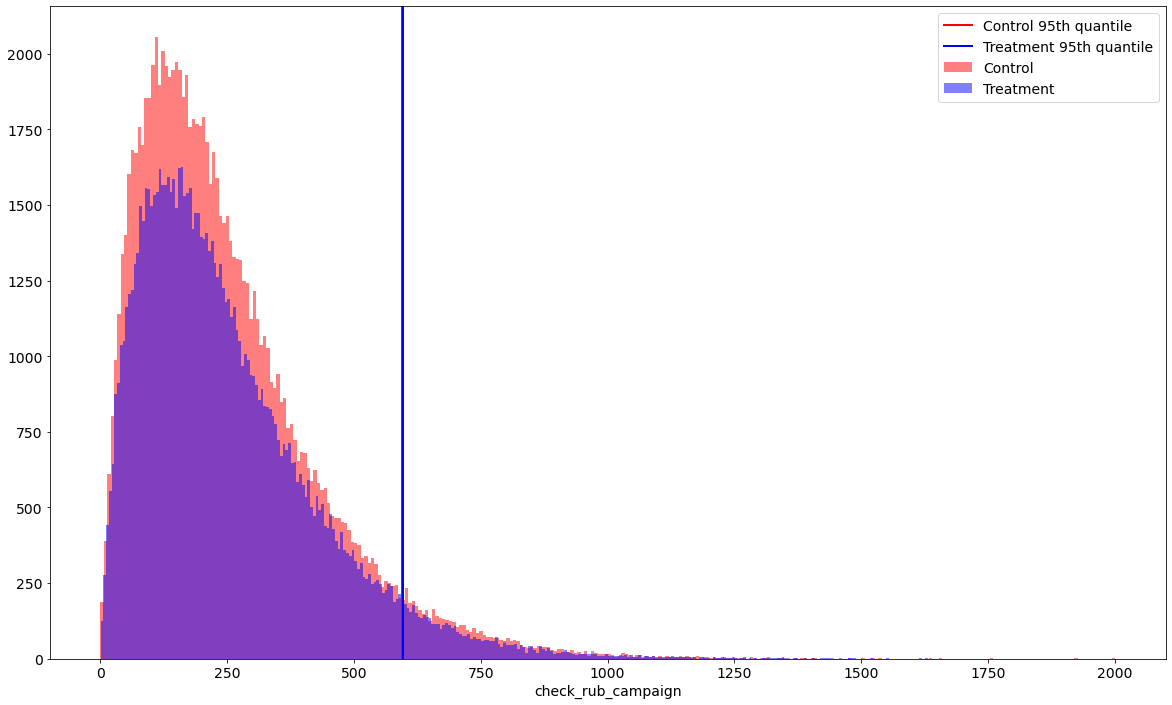

In [7]:
ab_test.plot()

In [8]:
ab_test.test_welch()

{'stat': 3.826835288277082, 'p-value': 6.492037933029886e-05, 'result': 1}

In [9]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: 95th quantile.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 99683
        - Mean: 249.8488
        - Median: 209.2000
        - 25th quantile: 120.3500
        - 75th quantile: 334.5000
        - Minimum: 0.3000
        - Maximum: 2000.1000
        - St.deviation: 177.3074
        - Variance: 31437.9144

        Treatment group:
        - Observations: 100317
        - Mean: 252.8821
        - Median: 212.6000
        - 25th quantile: 122.5000
        - 75th quantile: 340.9000
        - Minimum: 0.7000
        - Maximum: 1631.0000
        - St.deviation: 177.3074
        - Variance: 31437.9144

        No transformations applied.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 3.83, p-value = 0.0001, H0 is rejected.
        - Mann Whitney's U-test: 49

## Фильтрация выбросов

In [10]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean',
    filter_method='top_5',  # <----- метод фильтрации метрики эксперимента: top_5, isolation_forest
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

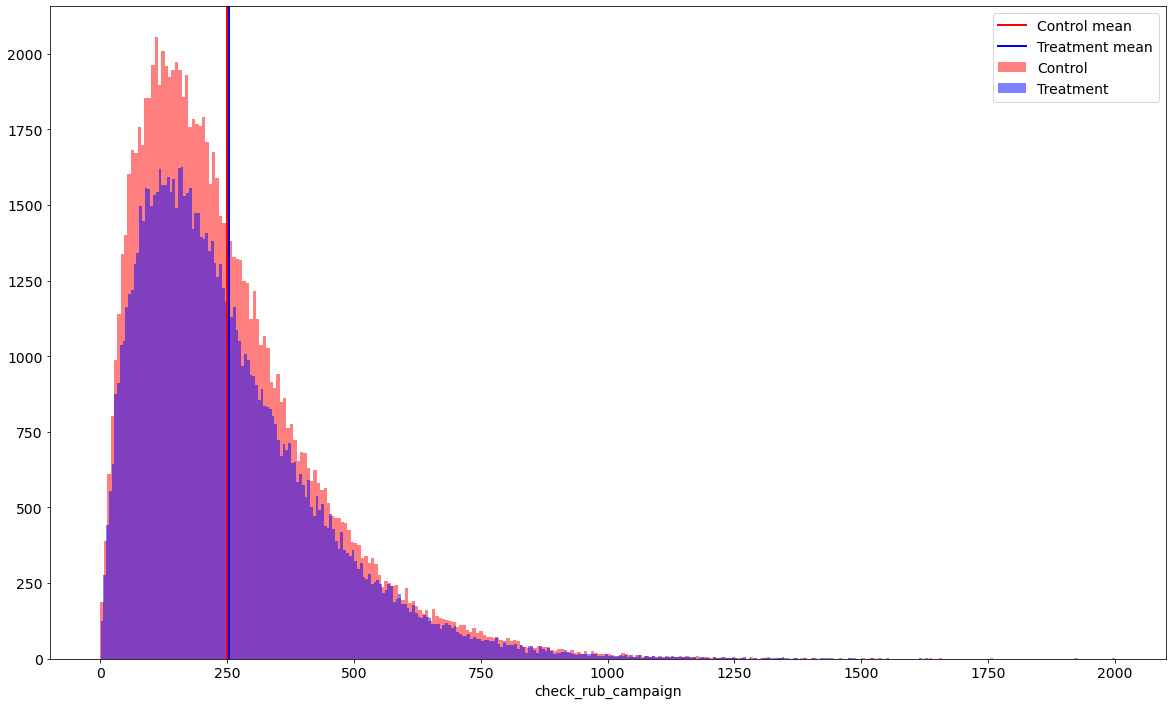

In [11]:
ab_test.plot()

In [12]:
ab_test.test_welch()

{'stat': 3.826835288277082, 'p-value': 6.492037933029886e-05, 'result': 1}

In [13]:
ab_test_1 = ab_test.filter_outliers()

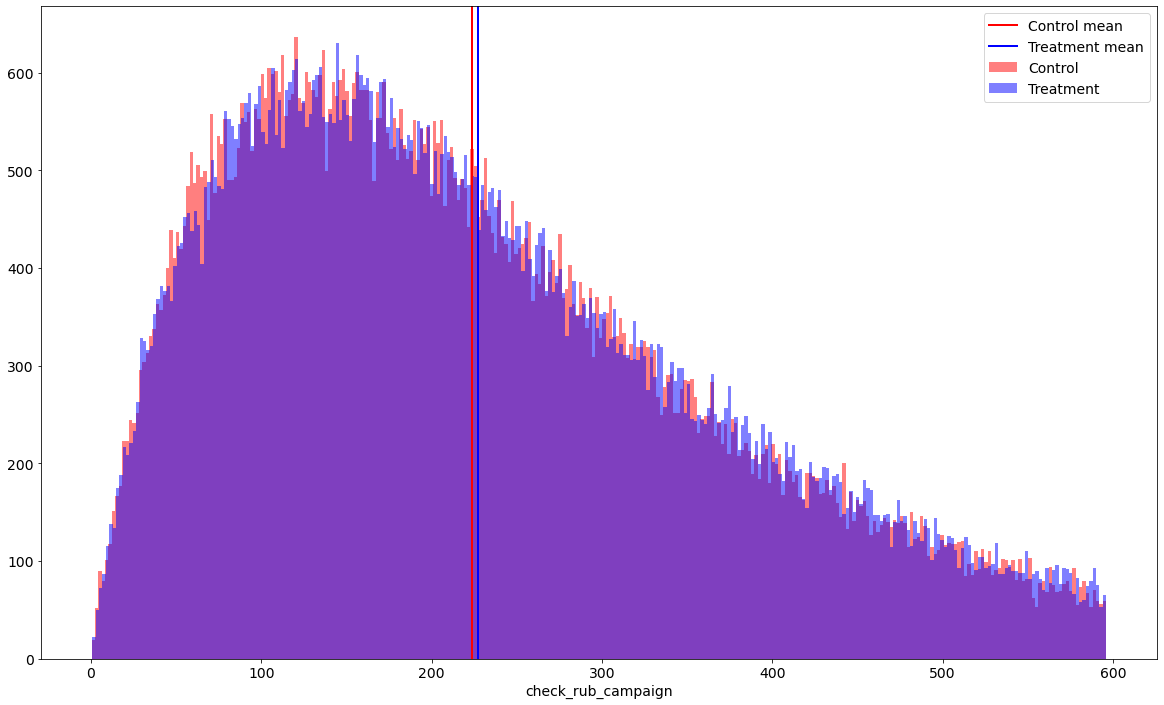

In [14]:
ab_test_1.plot()

## Функциональная трансформация метрики

In [15]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    metric_transform=np.sqrt,  # <----- добавлена трансформация
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

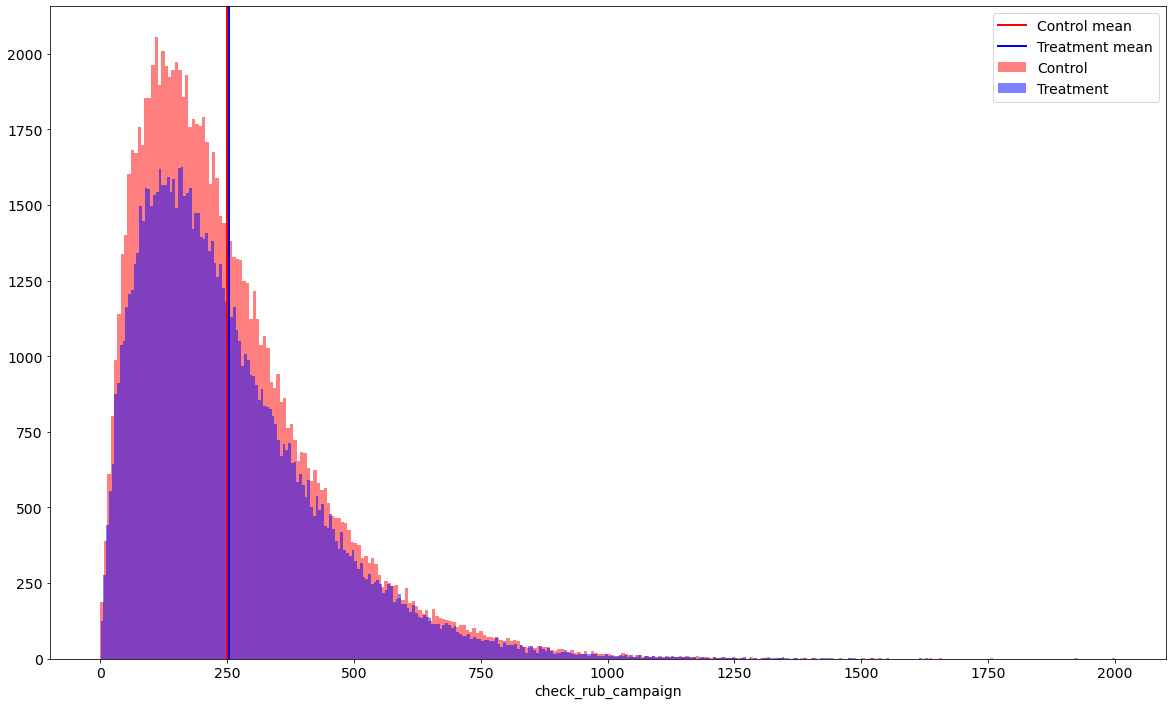

In [16]:
ab_test.plot()

In [17]:
ab_test_1 = ab_test.metric_transform()

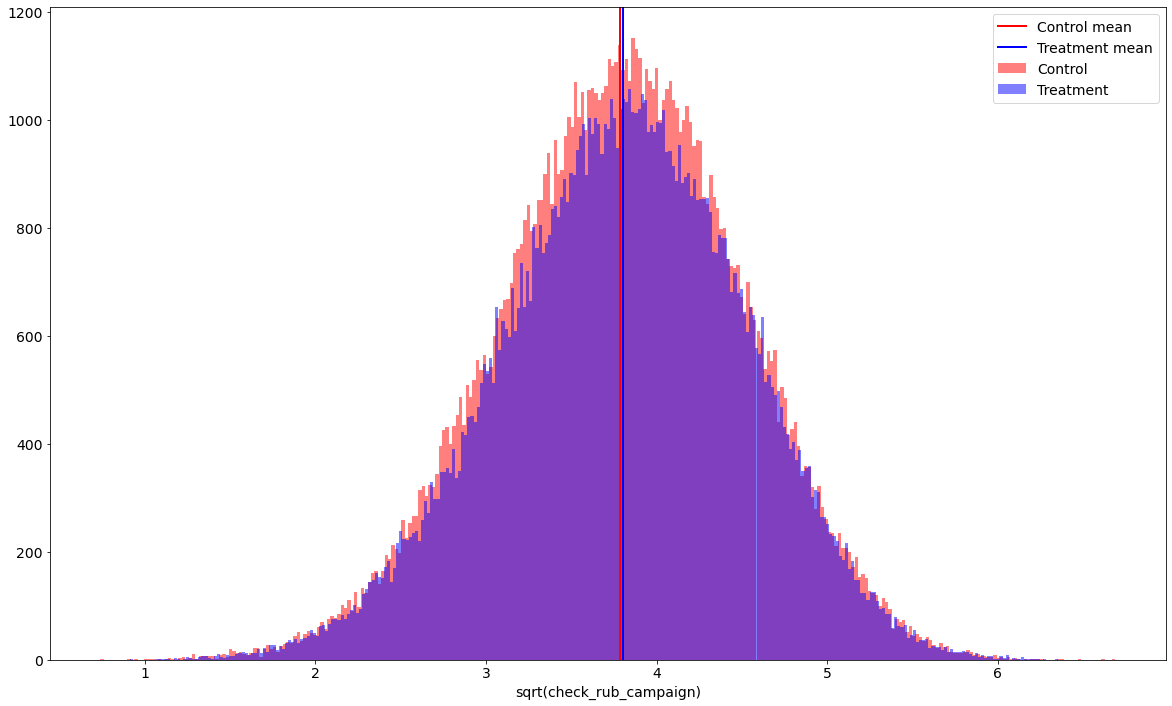

In [18]:
ab_test_1.plot()

In [19]:
ab_test_1.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 99683
        - Mean: 3.7877
        - Median: 3.8031
        - 25th quantile: 3.3122
        - 75th quantile: 4.2766
        - Minimum: 0.7401
        - Maximum: 6.6875
        - St.deviation: 0.7128
        - Variance: 0.5080

        Treatment group:
        - Observations: 100317
        - Mean: 3.8015
        - Median: 3.8185
        - 25th quantile: 3.3269
        - 75th quantile: 4.2969
        - Minimum: 0.9147
        - Maximum: 6.3550
        - St.deviation: 0.7128
        - Variance: 0.5080

        Transformations applied: metric transform.
        Number of bootstrap iterations: 1000. Metric transformation applied: sqrt. 

        Following statistical tests are used:
        - Welch's t-test: 4.33, p-value = 0.0000, H0 is rejected.
        - Mann Whitney's U

## Увеличение чувствительности метрики

In [20]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
    covariate='check_rub_pre_campaign',  # <----- добавляем информацию о ковариате
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [21]:
ab_test_1 = ab_test.cuped()

Среднее и ст.отклонение до CUPED:

In [22]:
print(np.mean(ab_test.params.data_params.control))
print(np.std(ab_test.params.data_params.control))

249.84880671729383
177.16631805039285


Среднее и ст.отклонение после CUPED:

In [23]:
print(np.mean(ab_test_1.params.data_params.control))
print(np.std(ab_test_1.params.data_params.control))

249.84880671729024
10.007087044876895


## Линеаризация и зависимые наблюдения

In [24]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=False,   # <----- данные не сгрупированы по user_id — по каждому user_id одна и более запись
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [25]:
print(f'Строк в старом датасете: {df.shape[0]}')
print(f'Уникальных user_id в старом датасете: {df.user_id.nunique()}')

Строк в старом датасете: 200000
Уникальных user_id в старом датасете: 125533


In [26]:
ab_test_1 = ab_test.linearization()

In [27]:
print('Строк в новом датасете: ' + str(ab_test_1._ABTest__dataset.shape[0]))
print('Уникальных user_id в новом датасете: ' + str(ab_test_1._ABTest__dataset.user_id.nunique()))

Строк в новом датасете: 125533
Уникальных user_id в новом датасете: 125533


In [28]:
ab_test_1._ABTest__dataset.head()

,groups,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration,target_linearized
0,control,18552,female,22,Moscow,26.9,24.605145,0,34,4,-222.94881
1,control,86133,female,65,St.Petersburg,247.8,241.853127,0,26,35,-2.04881
2,treatment,127815,male,26,Moscow,1028.4,1025.731490,0,48,7,785.70238
3,treatment,108774,female,43,Moscow,125.6,127.394025,0,39,53,-124.24881
4,treatment,164071,female,21,Moscow,278.2,276.548045,0,47,54,28.35119


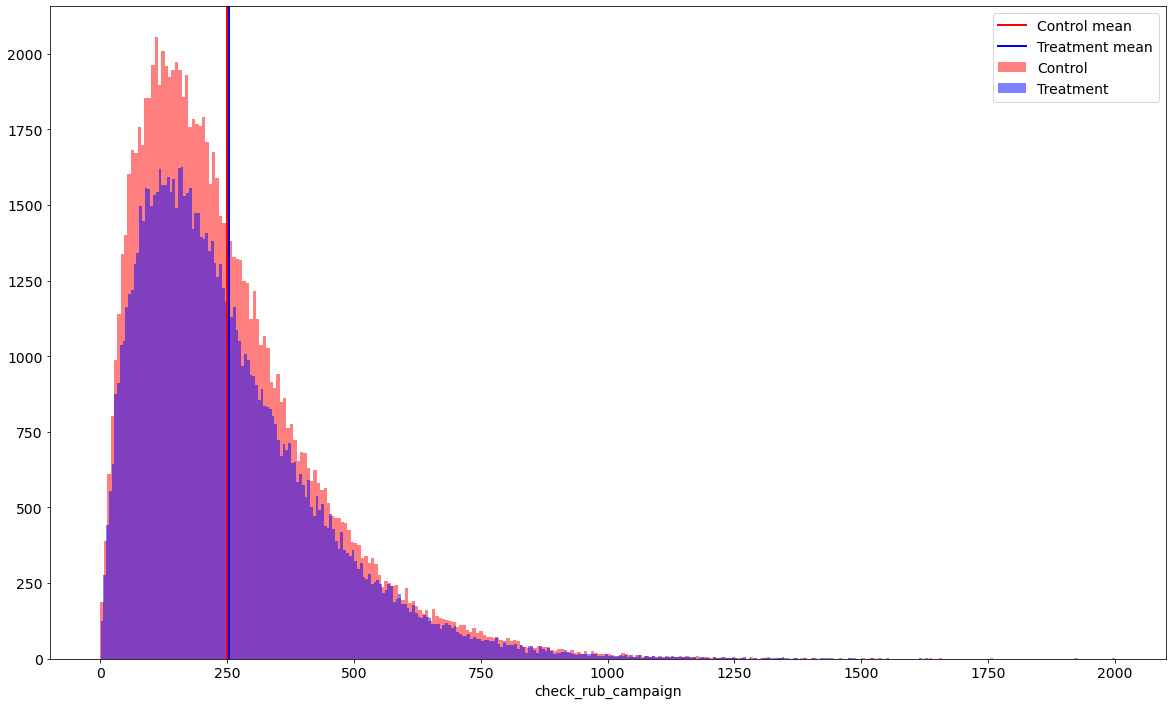

In [29]:
ab_test.plot()

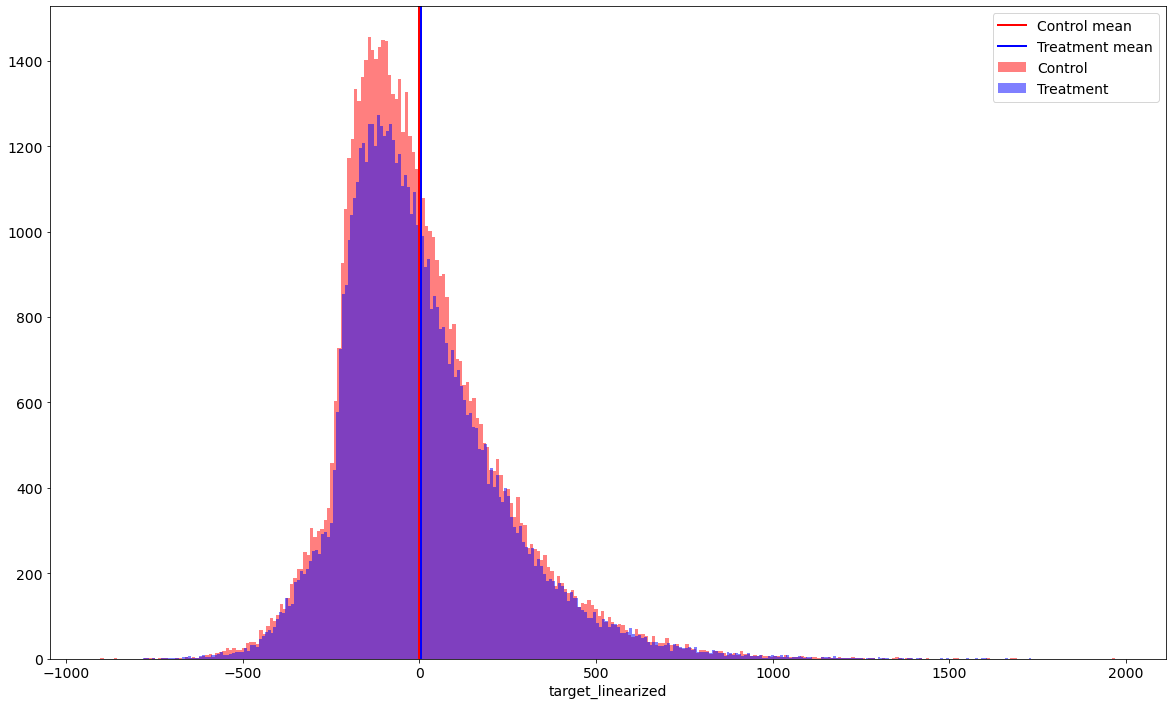

In [30]:
ab_test_1.plot()

In [31]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 99683
        - Mean: 249.8488
        - Median: 209.2000
        - 25th quantile: 120.3500
        - 75th quantile: 334.5000
        - Minimum: 0.3000
        - Maximum: 2000.1000
        - St.deviation: 177.3074
        - Variance: 31437.9144

        Treatment group:
        - Observations: 100317
        - Mean: 252.8821
        - Median: 212.6000
        - 25th quantile: 122.5000
        - 75th quantile: 340.9000
        - Minimum: 0.7000
        - Maximum: 1631.0000
        - St.deviation: 177.3074
        - Variance: 31437.9144

        No transformations applied.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 3.83, p-value = 0.0001, H0 is rejected.
        - Mann Whitney's U-test: 4940415397.

In [32]:
ab_test_1.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: mean.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 62527
        - Mean: -0.0000
        - Median: -40.6488
        - 25th quantile: -148.7488
        - 75th quantile: 109.3768
        - Minimum: -902.5929
        - Maximum: 1968.5024
        - St.deviation: 223.7597
        - Variance: 50068.4225

        Treatment group:
        - Observations: 63006
        - Mean: 4.8295
        - Median: -35.9464
        - 25th quantile: -144.9488
        - 75th quantile: 116.3512
        - Minimum: -781.5440
        - Maximum: 1732.2536
        - St.deviation: 223.7597
        - Variance: 50068.4225

        Transformations applied: linearization.
        Number of bootstrap iterations: 1000. 

        Following statistical tests are used:
        - Welch's t-test: 3.83, p-value = 0.0001, H0 is rejected.
        - Mann Whitney's U-t

## Метрика-отношение

In [33]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=False,
    numerator='clicks',  # <----- числитель
    denominator='session_duration'  # <----- знаменатель
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='ratio', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [34]:
ab_test.test_taylor_ratio()

{'stat': -82.61980556022617, 'p-value': None, 'result': 0}

Добавляем в числитель клики:

In [35]:
df1 = df.copy(deep=True)
df1.loc[df.groups == 'treatment', 'clicks'] = df1.loc[df1.groups == 'treatment', 'clicks'] \
                                                    + np.random.normal(2, 1, df1.loc[df.groups == 'treatment'].shape[0])
ab_test_up = ABTest(df1, ab_params)
ab_test_up.test_taylor_ratio()

{'stat': 2147.821946020265, 'p-value': None, 'result': 0}

Линеаризируем и смотрим результат после применения:

In [36]:
ab_test_1 = ab_test.linearization()
ab_test_up_1 = ab_test_up.linearization()

In [37]:
print(ab_test_1.test_welch())
print(ab_test_up_1.test_welch())

{'stat': -0.5960722385963354, 'p-value': 0.7244359780572207, 'result': 0}
{'stat': 15.24048758870443, 'p-value': 1.0610673227841184e-52, 'result': 1}


## Бакетирование

In [38]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000,
    n_buckets=1000  # <----- количество бакетов
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

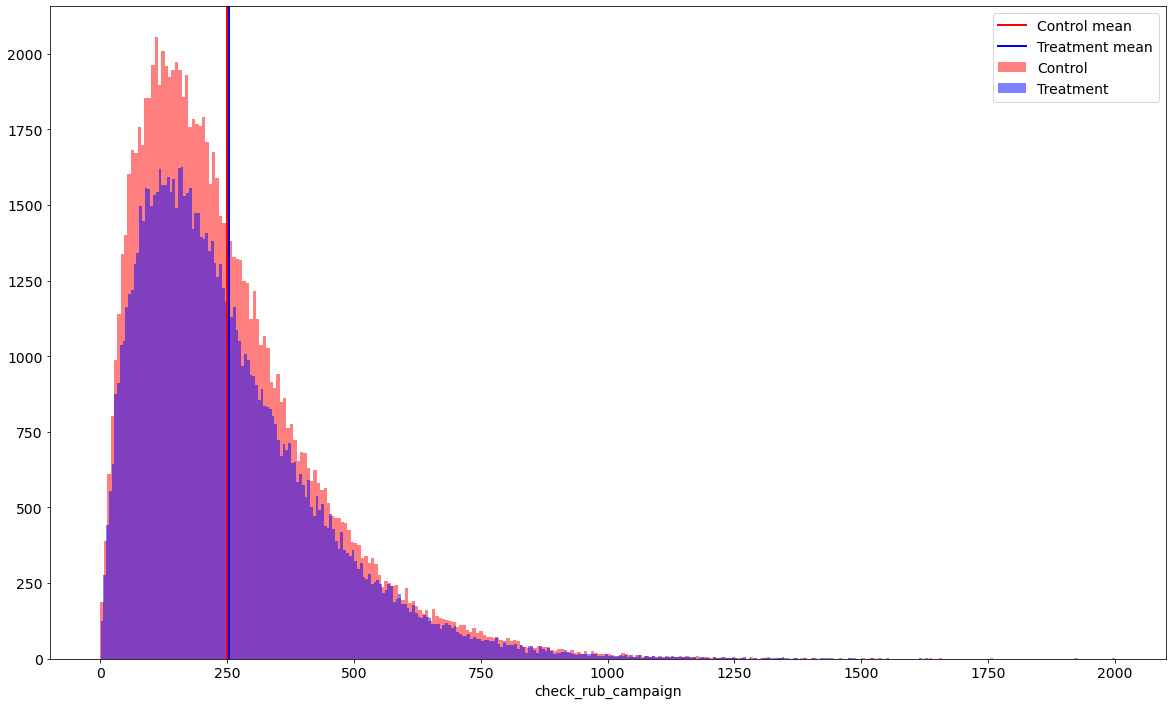

In [39]:
ab_test.plot()

In [40]:
ab_test_1 = ab_test.bucketing()

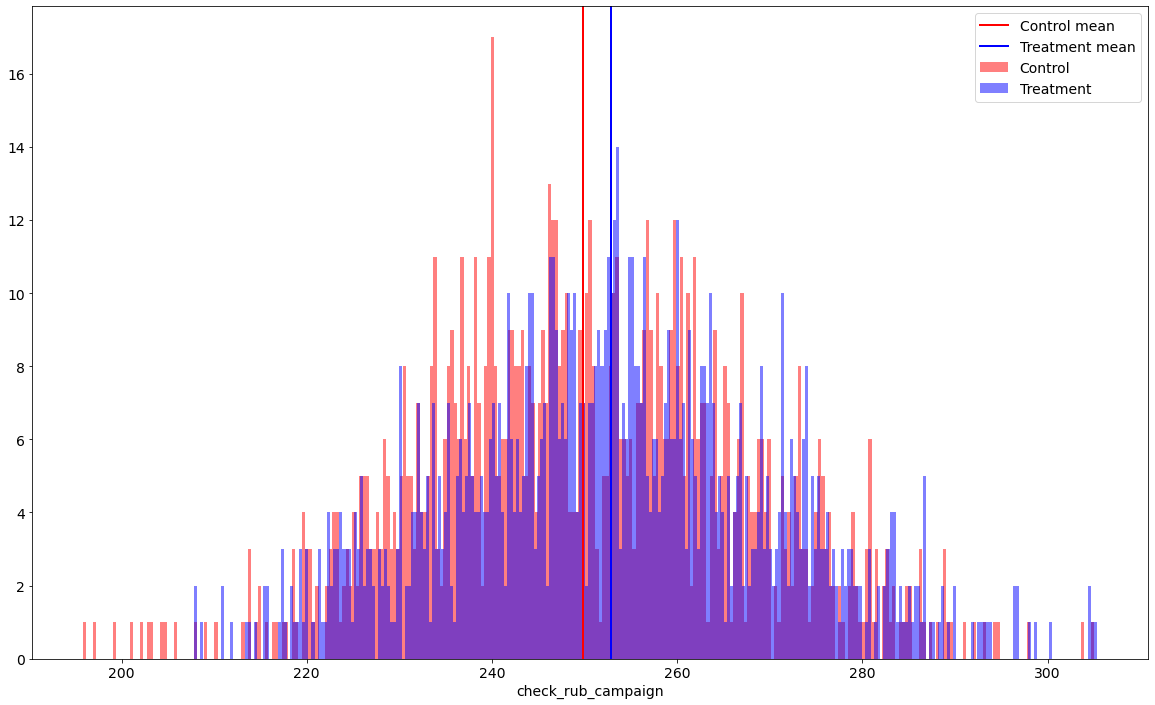

In [41]:
ab_test_1.plot()

Сравниваем средние до и после бакетирования:

In [42]:
print('До бакетирования:')
print(np.mean(ab_test.params.data_params.control))
print(np.mean(ab_test.params.data_params.treatment))
print('\nПосле бакетирования:')
print(np.mean(ab_test_1.params.data_params.control))
print(np.mean(ab_test_1.params.data_params.treatment))

До бакетирования:
249.84880671729383
252.88208778173188

После бакетирования:
249.84525268686872
252.88275974257425


## Всё вместе

In [44]:
df = pd.read_csv('./data/ab_data_new.csv')

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    covariate='check_rub_pre_campaign',
    is_grouped=False,
    target='check_rub_campaign'
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='median',
    metric_transform=np.sqrt,
    filter_method='top_5',
    n_boot_samples=1000,
    n_buckets=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)

In [45]:
ab_test = ABTest(df, ab_params).metric_transform().filter_outliers().linearization().cuped().bucketing()

In [46]:
ab_test.report()


        Parameters of experiment:
        - Metric type: continuous.
        - Metric: median.
        - Errors: alpha = 0.01, beta = 0.2.
        - Alternative: greater.

        Control group:
        - Observations: 1000
        - Mean: 0.1987
        - Median: 0.2146
        - 25th quantile: 0.0868
        - 75th quantile: 0.3247
        - Minimum: -0.7493
        - Maximum: 0.7020
        - St.deviation: 0.1915
        - Variance: 0.0367

        Treatment group:
        - Observations: 1000
        - Mean: 0.3395
        - Median: 0.3578
        - 25th quantile: 0.2260
        - 75th quantile: 0.4809
        - Minimum: -0.6354
        - Maximum: 0.8430
        - St.deviation: 0.1915
        - Variance: 0.0367

        Transformations applied: metric transform -> filter outliers -> linearization -> cuped -> bucketing.
        Number of bootstrap iterations: 1000. Number of buckets: 1000. Metric transformation applied: sqrt. Outliers filtering method applied: top_5. 

        Foll

# Пост-анализ для метрики "конверсия"
## Инициализация теста, иллюстрация, запуск теста и отчет

In [47]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop_duplicates(['user_id'])

data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target_flg='has_transaction'  # <----- для конверсии задаем целевую колонку в этот аргумент
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='binary', 
    metric_name='mean',  # <----- обязательное использование метрики "среднее"
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [48]:
ab_test.report()

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.007660690581668719

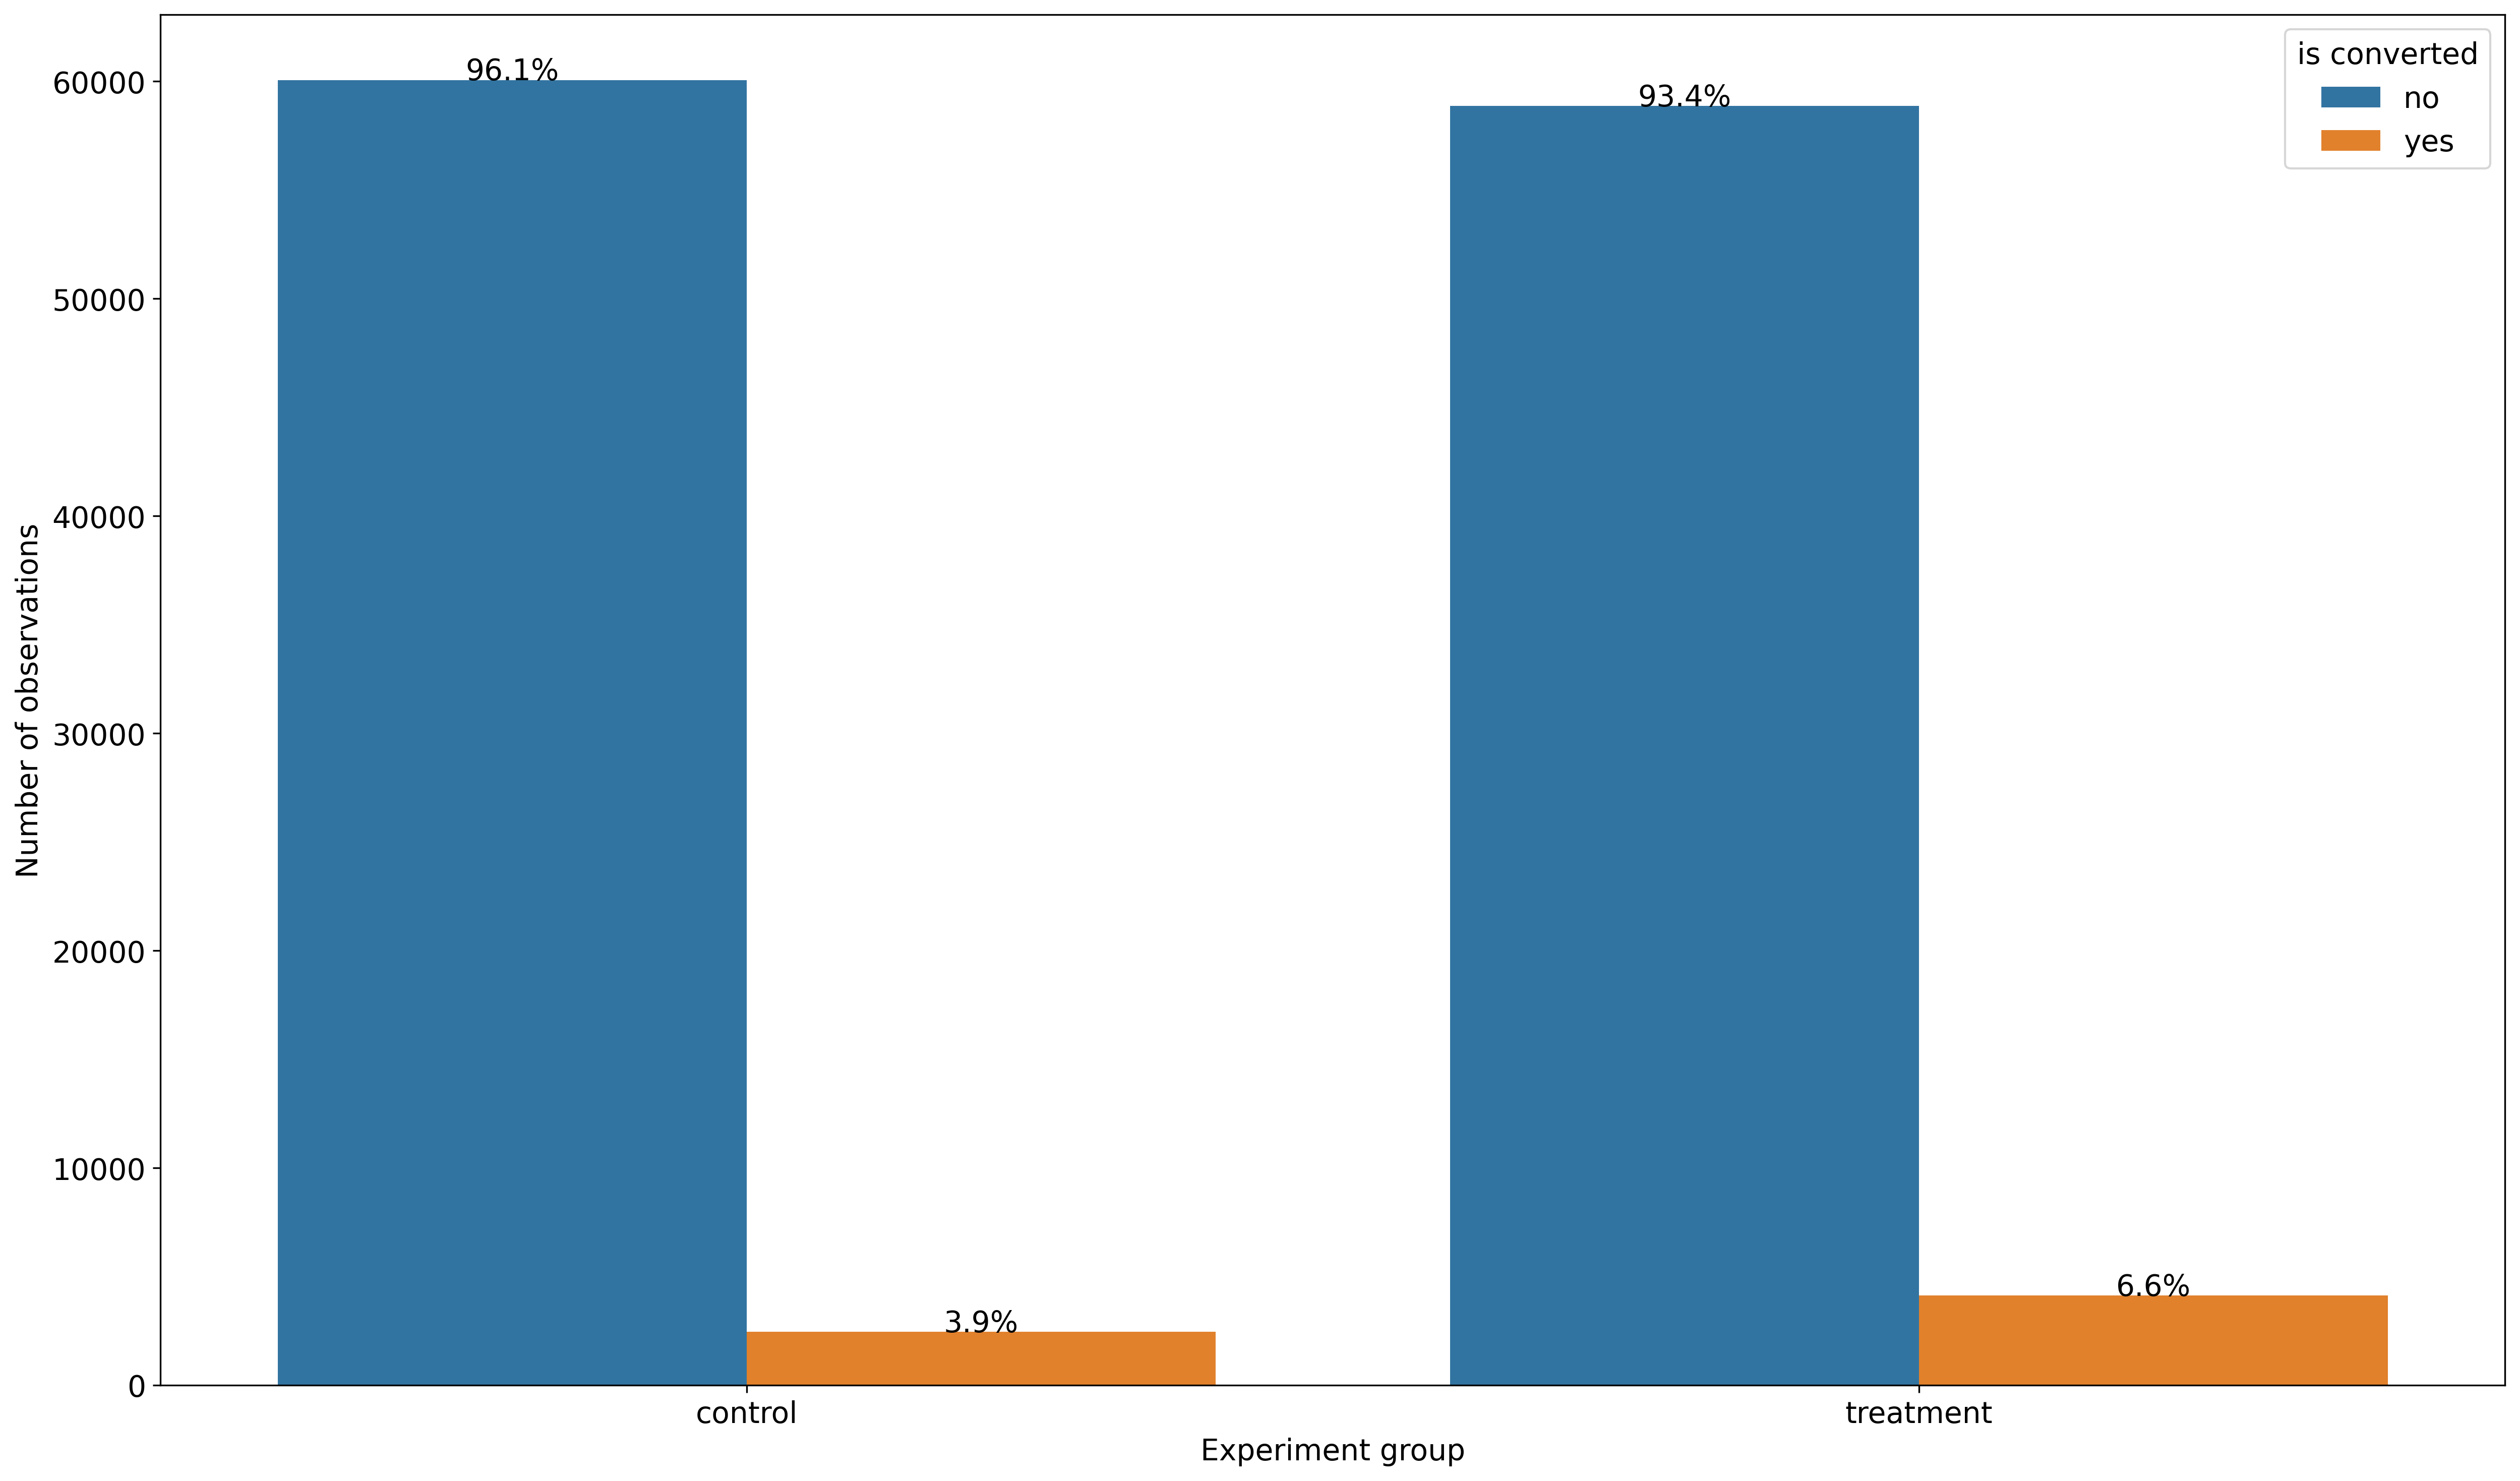

In [50]:
ab_test.plot()

# Выделение групп эксперимента
## Разделение на группы всех имеющихся данных

In [51]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop(columns=['groups'])
df = df.drop_duplicates(['user_id'])

In [53]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None,
        'target': None
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 100
)

In [54]:
split_builder = SplitBuilder(df, split_builder_params)

In [55]:
split = split_builder.collect()

In [56]:
split.head()

,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration,strata,group_name
0,18552,0.648427,22,Moscow,26.9,24.605145,0,34,4,Moscow0-1,target
1,86133,0.648427,65,St.Petersburg,247.8,241.853127,0,26,35,St.Petersburg3-1,control
2,127815,0.351573,26,Moscow,1028.4,1025.731490,0,48,7,Moscow5-1,target
3,108774,0.648427,43,Moscow,125.6,127.394025,0,39,53,Moscow14,target
4,164071,0.648427,21,Moscow,278.2,276.548045,0,47,54,Moscow30,target


In [57]:
print(f'Количество строк исходно: {df.shape[0]}')
print(f'Количество строк в сплите: {split.shape[0]}')

Количество строк исходно: 125533
Количество строк в сплите: 125519


## Разделение на группы с требуемым размером

In [58]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop(columns=['groups'])
df = df.drop_duplicates(['user_id'])

In [60]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': 20_000,  # <----- размер контрольной группы
        'target': 30_000  # <----- размер тестовой группы
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

In [61]:
split_builder = SplitBuilder(df, split_builder_params)

In [62]:
split = split_builder.collect()

In [63]:
split.head()

,user_id,gender,age,city,check_rub_campaign,check_rub_pre_campaign,has_transaction,clicks,session_duration,strata,group_name
0,127815,0.351573,26,Moscow,1028.4,1025.731490,0,48,7,Moscow5-1,control
1,92766,0.648428,21,Moscow,345.9,358.387740,0,7,29,Moscow4-1,control
2,49963,0.351573,42,Moscow,145.3,129.911655,0,5,49,Moscow1-1,target
3,10020,0.648428,54,St.Petersburg,275.7,262.848778,0,7,57,St.Petersburg3-1,target
4,191969,0.351573,59,Moscow,105.3,99.209423,0,24,107,Moscow1-1,control


In [64]:
print(f'Количество строк исходно: {df.shape[0]}')
print(f'Количество строк в сплите: {split.shape[0]}')
print(f'Количество строк в контроле: {split[split.group_name == "control"].shape[0]}')
print(f'Количество строк в тесте: {split[split.group_name == "target"].shape[0]}')

Количество строк исходно: 125533
Количество строк в сплите: 49998
Количество строк в контроле: 20000
Количество строк в тесте: 29998


# Подбор параметров эксперимента
## Непрерывная метрика, без трансформаций

In [65]:
df = pd.read_csv('./data/ab_data_new.csv')
df = df.drop_duplicates(['user_id'])

In [66]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign' 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [68]:
split_builder_params = SplitBuilderParams(
    map_group_names_to_sizes={
        'control': None, 
        'target': None
    },
    main_strata_col = "city",
    split_metric_col = "check_rub_campaign",
    id_col = "user_id",
    cols = ["check_rub_pre_campaign"],
    cat_cols=["gender"],
    alpha=0.05,
    n_bins = 6,
    min_cluster_size = 500
)

In [69]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [70]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [71]:
beta, alpha = prepilot.collect()

In [74]:
beta

split_rate                (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             Effect                                              
check_rub_campaign 1.0%          >=0.9          >=0.9          >=0.9   
                   1.3%          >=0.9          >=0.9          >=0.9   
                   1.5%          >=0.9          >=0.9          >=0.9   
                   1.8%          >=0.9          >=0.9            0.5   
                   2.0%          >=0.9          >=0.9          <=0.2   
                   3.0%            0.8          <=0.2          <=0.2   

split_rate                (20000, 20000) (25000, 25000) (30000, 30000)  
metric             Effect                                               
check_rub_campaign 1.0%            >=0.9          >=0.9          >=0.9  
                   1.3%            >=0.9          >=0.9            0.5  
                   1.5%              0.8            0.5            0.3  
                   1.8%              0.4          <=0.2          <=0.2  
                   2.0%            <=0.2          <=0.2          <=0.2  
                   3.0%            <=0.2          <=0.2          <=0.2

In [75]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.0,0.0,0.0,0.0,0.0,0.0


## Непрерывная метрика, понижение дисперсии

In [76]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target='check_rub_campaign', 
    covariate='check_rub_pre_campaign'  # <----- добавили ковариату
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='solid', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [77]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=ABTest.cuped,
    use_buckets=False,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [78]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [79]:
beta, alpha = prepilot.collect()

In [80]:
beta

split_rate                (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             Effect                                              
check_rub_campaign 1.0%          <=0.2          <=0.2          <=0.2   
                   1.3%          <=0.2          <=0.2          <=0.2   
                   1.5%          <=0.2          <=0.2          <=0.2   
                   1.8%          <=0.2          <=0.2          <=0.2   
                   2.0%          <=0.2          <=0.2          <=0.2   
                   3.0%          <=0.2          <=0.2          <=0.2   

split_rate                (20000, 20000) (25000, 25000) (30000, 30000)  
metric             Effect                                               
check_rub_campaign 1.0%            <=0.2          <=0.2          <=0.2  
                   1.3%            <=0.2          <=0.2          <=0.2  
                   1.5%            <=0.2          <=0.2          <=0.2  
                   1.8%            <=0.2          <=0.2          <=0.2  
                   2.0%            <=0.2          <=0.2          <=0.2  
                   3.0%            <=0.2          <=0.2          <=0.2

In [81]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.1,0.2,0.4,0.7,0.3,0.3


## Непрерывная метрика, бакетирование

In [82]:
experiment_params = MdeParams(
    metrics_names=['check_rub_campaign'],
    injects=[1.010, 1.013, 1.015, 1.018, 1.02, 1.030],
    min_group_size=5_000, 
    max_group_size=30_000, 
    step=5_000,
    variance_reduction=ABTest.cuped,
    use_buckets=True,
    stat_test=ABTest.test_welch,
    iterations_number=10,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [83]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [84]:
beta, alpha = prepilot.collect()

In [85]:
beta

split_rate                (5000, 5000) (10000, 10000) (15000, 15000)  \
metric             Effect                                              
check_rub_campaign 1.0%            0.3          <=0.2          <=0.2   
                   1.3%          <=0.2          <=0.2          <=0.2   
                   1.5%          <=0.2          <=0.2          <=0.2   
                   1.8%          <=0.2          <=0.2          <=0.2   
                   2.0%          <=0.2          <=0.2          <=0.2   
                   3.0%          <=0.2          <=0.2          <=0.2   

split_rate                (20000, 20000) (25000, 25000) (30000, 30000)  
metric             Effect                                               
check_rub_campaign 1.0%            <=0.2          <=0.2          <=0.2  
                   1.3%            <=0.2          <=0.2          <=0.2  
                   1.5%            <=0.2          <=0.2          <=0.2  
                   1.8%            <=0.2          <=0.2          <=0.2  
                   2.0%            <=0.2          <=0.2          <=0.2  
                   3.0%            <=0.2          <=0.2          <=0.2

In [86]:
alpha

split_rate,"(5000, 5000)","(10000, 10000)","(15000, 15000)","(20000, 20000)","(25000, 25000)","(30000, 30000)"
metric,,,,,,
check_rub_campaign,0.2,0.1,0.4,0.5,0.3,0.3


## Бинарная метрика

In [87]:
data_params = DataParams(
    id_col='user_id', 
    group_col='groups',
    control_name='control',
    treatment_name='treatment',
    is_grouped=True,
    target_flg='has_transaction', 
)

hypothesis_params = HypothesisParams(
    alpha=0.01, 
    beta=0.2, 
    alternative='greater', 
    metric_type='binary', 
    metric_name='mean', 
    n_boot_samples=1000
)

ab_params = ABTestParams(data_params, hypothesis_params)
ab_test = ABTest(df, ab_params)

In [88]:
experiment_params = MdeParams(
    metrics_names=['has_transaction'],
    injects=[1.05, 1.10, 1.15, 1.20],
    min_group_size=10_000, 
    max_group_size=30_000, 
    step=10_000,
    variance_reduction=None,
    use_buckets=False,
    stat_test=ABTest.test_z_proportions,
    iterations_number=100,
    max_beta_score=0.9,
    min_beta_score=0.2,
)

In [89]:
prepilot = MdeResearchBuilder(df, 
                              ab_params,
                              experiment_params,
                              split_builder_params)

In [90]:
beta, alpha = prepilot.collect()

In [91]:
beta

split_rate             (10000, 10000) (20000, 20000) (30000, 30000)
metric          Effect                                             
has_transaction 10.0%            0.79           0.43           0.34
                15.0%            0.39          <=0.2          <=0.2
                20.0%            0.28          <=0.2          <=0.2
                5.0%            >=0.9           0.85           0.81

In [93]:
alpha

split_rate,"(10000, 10000)","(20000, 20000)","(30000, 30000)"
metric,,,
has_transaction,0.01,0.01,0.01
